<a href="https://colab.research.google.com/github/shubhamkarkar/DesignOptimization2021Fall/blob/main/Project/Project_(Testing_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT-1 :
ROCKET LANDING**

Name : Shubham Ashok Karkar

ASU ID : 1223319344

October 20th, 2021



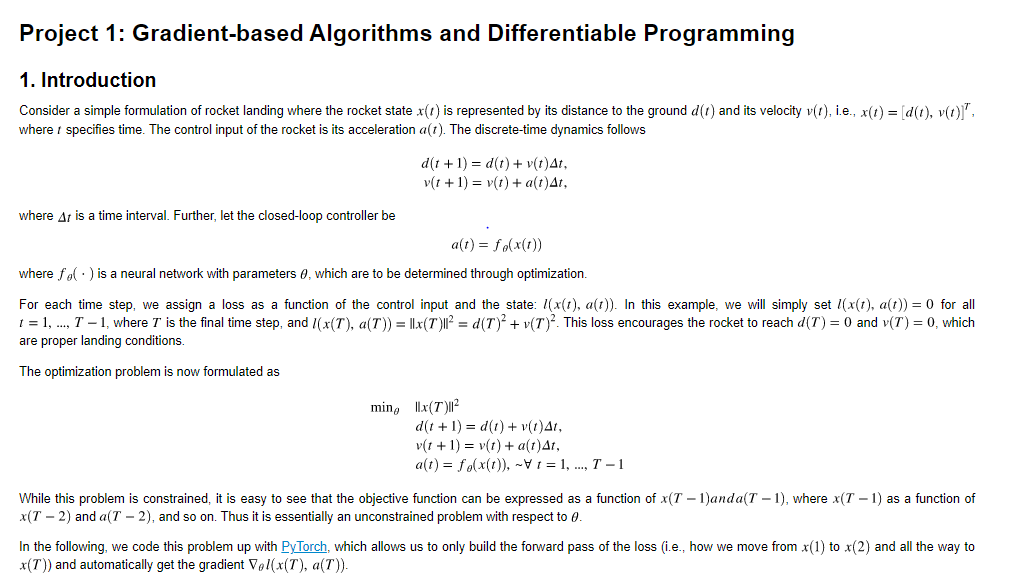

**1.Documentation of the problem formulation:** 

*FOR A BETTER PROBLEM FORMULATION :*


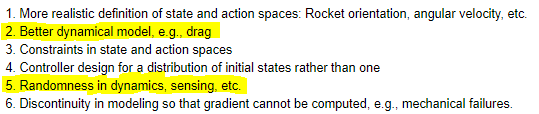
 


Problem Defination: 

From the above options given in the lecture, we decide to go with the drag and randomness in the dynamics. 
Let's assume that the rocket has an initial position of (20,0) and it has to reach it's destination i.e.(0,0).

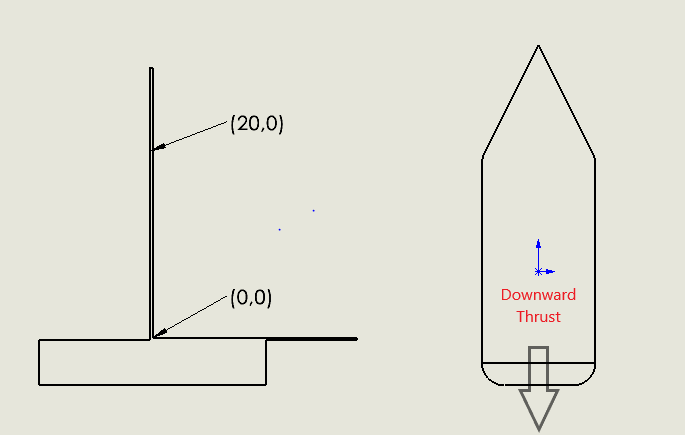

**Problem Formulation :**

In the given rocket landing problem, the rocket has an initial starting of (20.0) upto a destination of (0,0). The primary goal of the rocket is to land it close to the ground. 

In [66]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


In [79]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant

BOOST_ACCEL = 13  # thrust constant
LEFT_SIDE_BOOST_ACCEL = 0.2

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
ROTATION_ACCEL = 0.7  # rotation constant

In [80]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
       
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        ## delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        ## delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        
        ## temp = delta_state
        
        """"
        The following is the cacluctions and assumptions made to incorporate the drag effect in our rocket landing model
        
        Drag force: D = Cd * A * .5 * r * V^2
        Rocket in assumption is falcon 9
        Cd = 0.25 (Drag co-efficint of long cyclinder with a cone nose) 
        ref: https://space.stackexchange.com/questions/16883/whats-the-atmospheric-drag-coefficient-of-a-falcon-9-at-launch-sub-sonic-larg
        A = pi * 12 feet ^2 (Diameter of falcon 9) = 34 m^2
        r = 850 kg/m^3 (Density of steel)
        V = velocity = delta state
        m = 549054 Kg (Mass of falcon 9)
        
        D = 0.25 * 34 * 0.5 * 850 * delta_state**2
        
        also applying force balance on the rocket
        
        m * DRAG_DECEL (deceleration due to drag) = D
        DRAG_DECEL = 0.00658 * delta_state**2
        
        """
        #Updating drag
        
        delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME, 0, 0]) # (ADDED)

        temp = 58 #m/s

        DRAG_DECEL = 0.00658 * temp* temp
        
        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL

        delta_state = NET_ACCEL * FRAME_TIME * t.tensor([0., 1., 0., 0.]) * action[1] # (ADDED)

        delta_state_rotation = t.tensor([0., 0, 0, ROTATION_ACCEL* FRAME_TIME]) # (ADDED)

        delta_state_angular = LEFT_SIDE_BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0, 0, -1.]) * action[0] # (ADDED)

        state = state + delta_state + delta_state_gravity + delta_state_rotation + delta_state_angular # (ADDED)

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.], 
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]]) # (ADDED)

        state = t.matmul(step_mat, state)

        #Re-calculating new velocity
        ## delta_state = NET_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        ## state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
      
        return state

In [81]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(), #new layer
            nn.Tanh(), #new layer
            nn.Linear(dim_hidden, dim_hidden),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [82]:

# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [20., 0., 2., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [83]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done



class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.5f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        angle = data[:, 2]
        angular_velocity = data[:, 3]

        plt.figure(figsize=[16,12])
        plt.subplot(2,2,1)
        plt.plot(x, y) 
        plt.title('Distance vs velocity')
        plt.xlabel('Distance_x')
        plt.ylabel('Velocity_v')

        plt.subplot(2,2,2)
        plt.plot(angle, angular_velocity)
        plt.xlabel("angle")
        plt.ylabel("angular velocity")
        plt.show()

        

[1] loss: 318265.62500


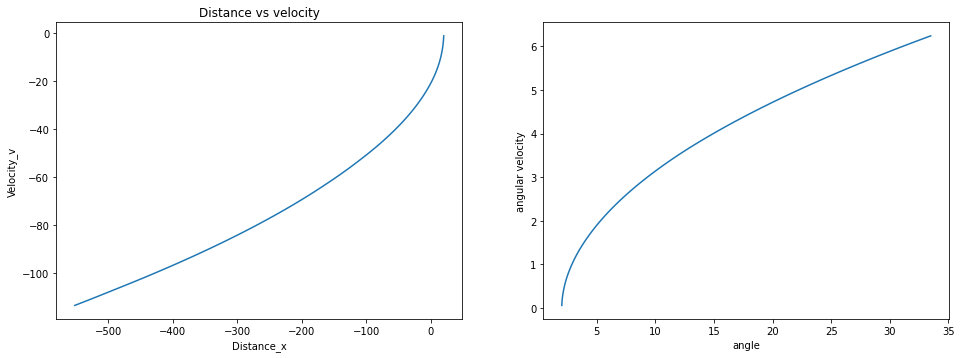

[2] loss: 270429.87500


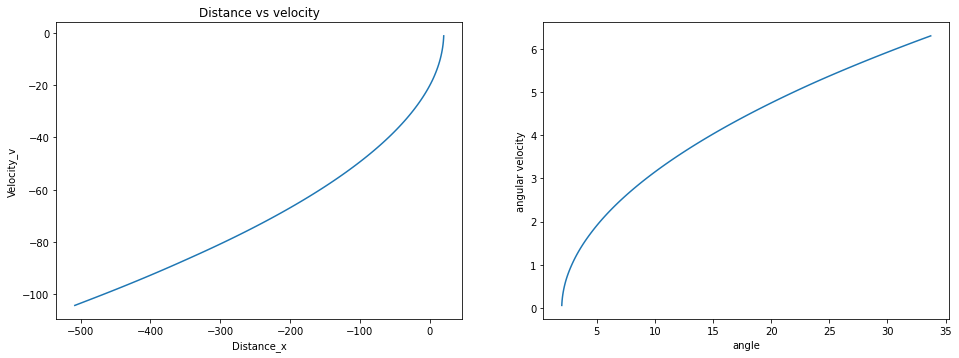

[3] loss: 256352.10938


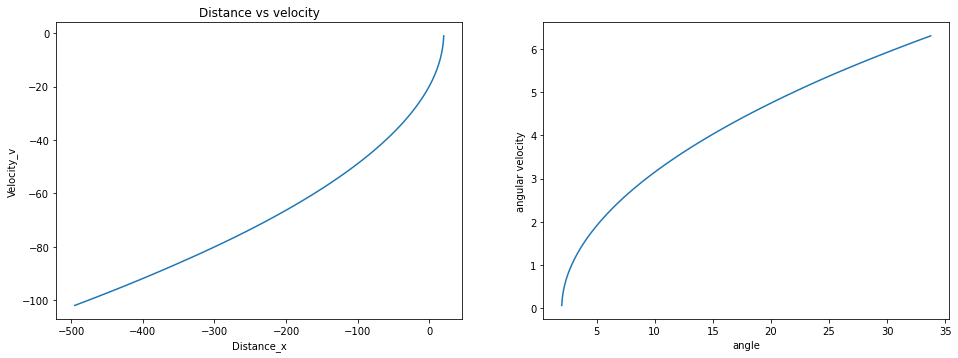

[4] loss: 248002.68750


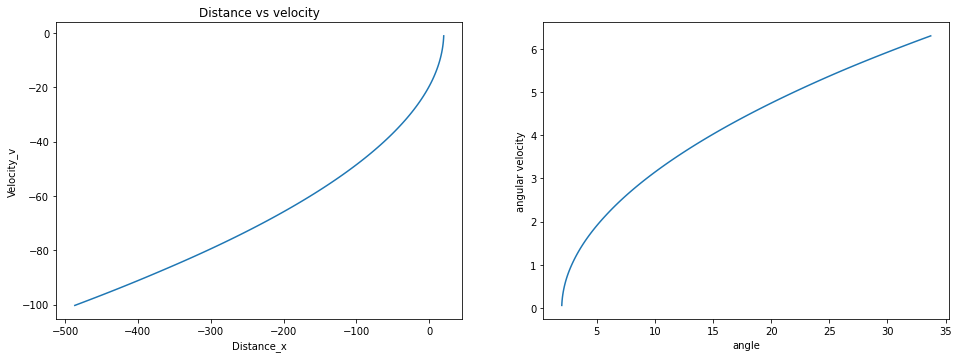

[5] loss: 243318.96875


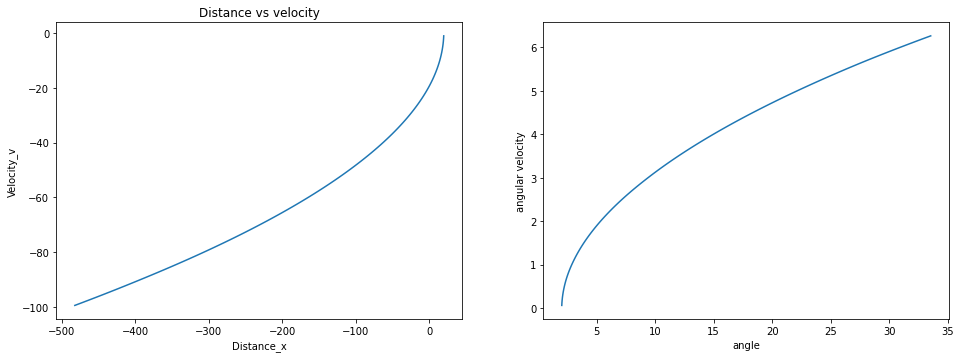

[6] loss: 240127.57812


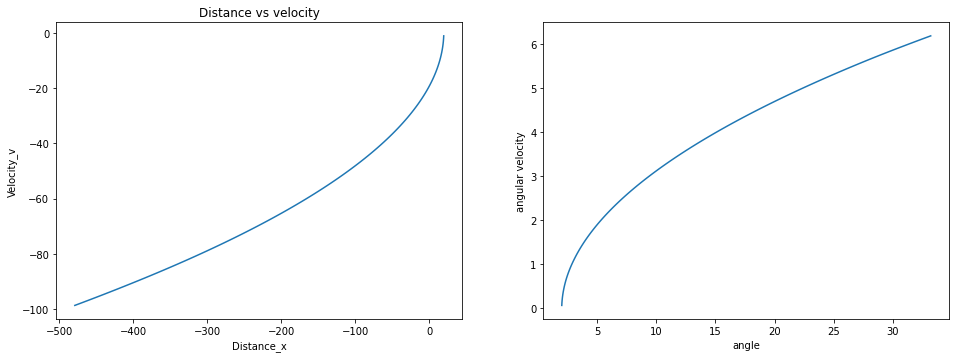

[7] loss: 239097.12500


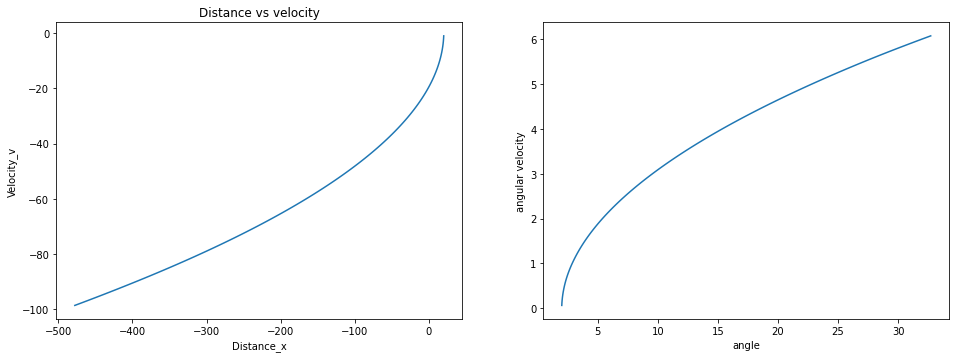

[8] loss: 238199.35938


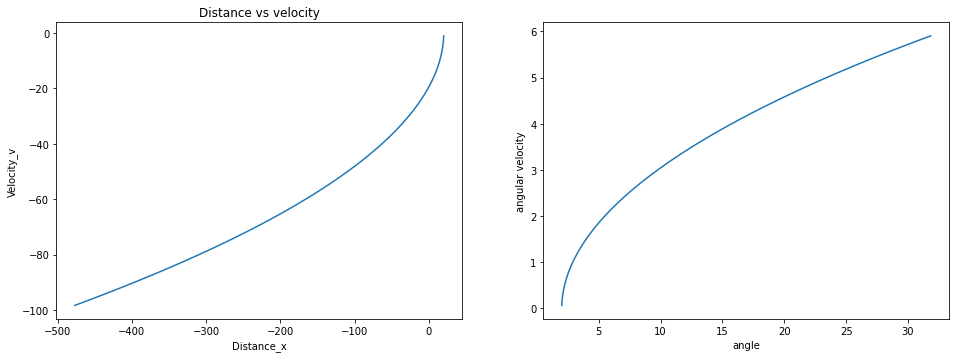

[9] loss: 237557.48438


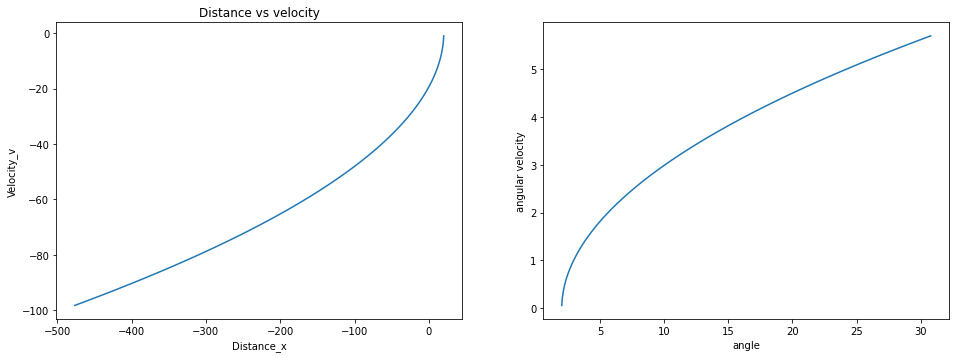

[10] loss: 236969.62500


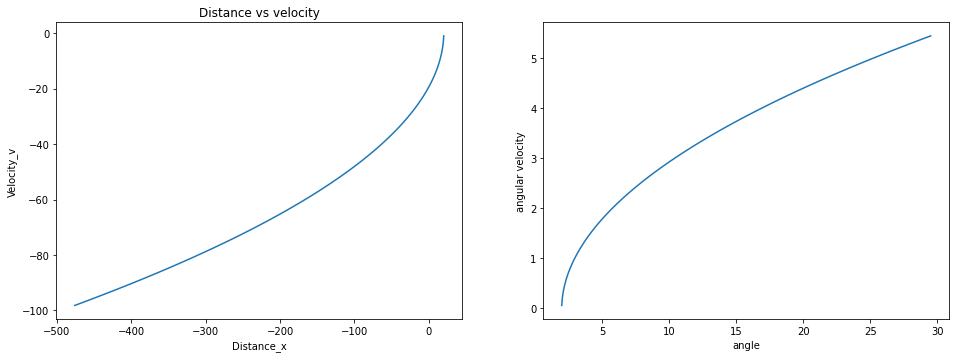

[11] loss: 236790.09375


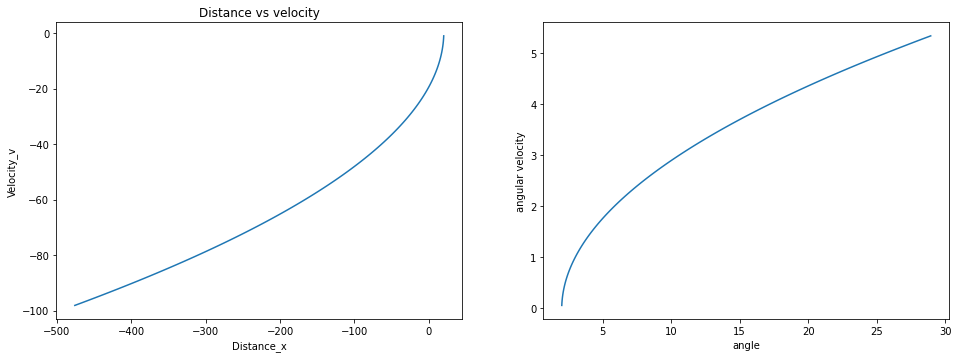

[12] loss: 236606.46875


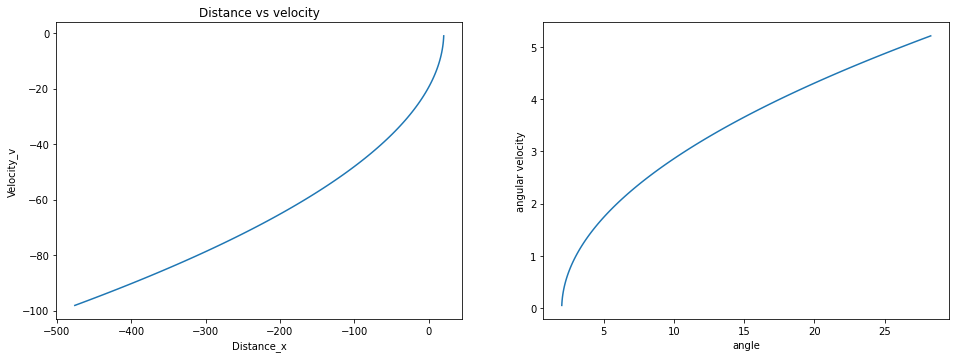

[13] loss: 236543.68750


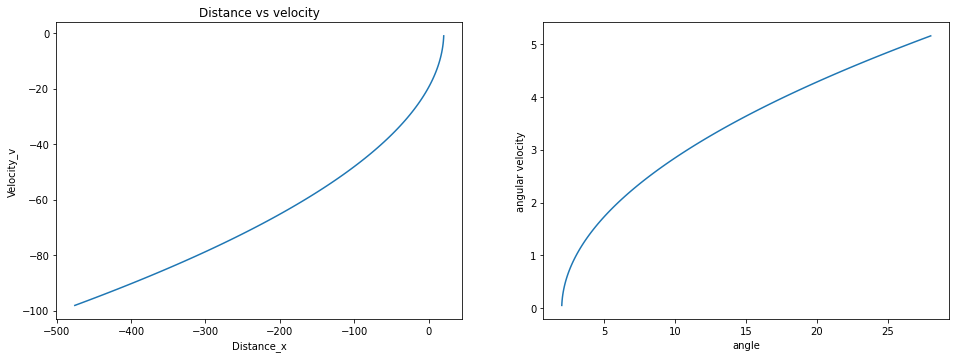

[14] loss: 236491.09375


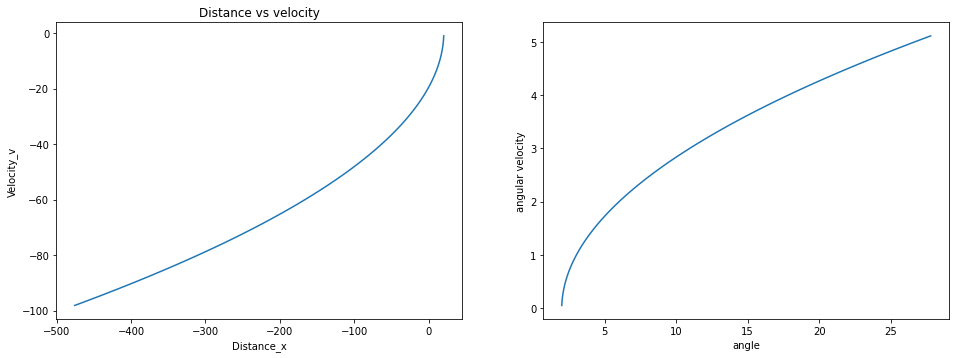

[15] loss: 236460.32812


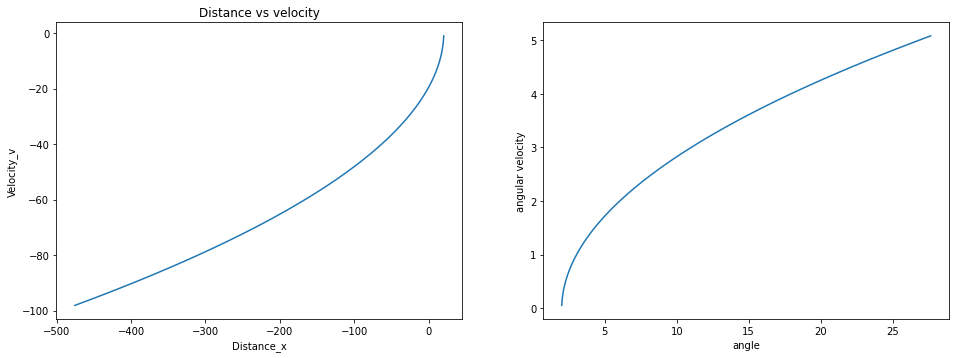

[16] loss: 236442.09375


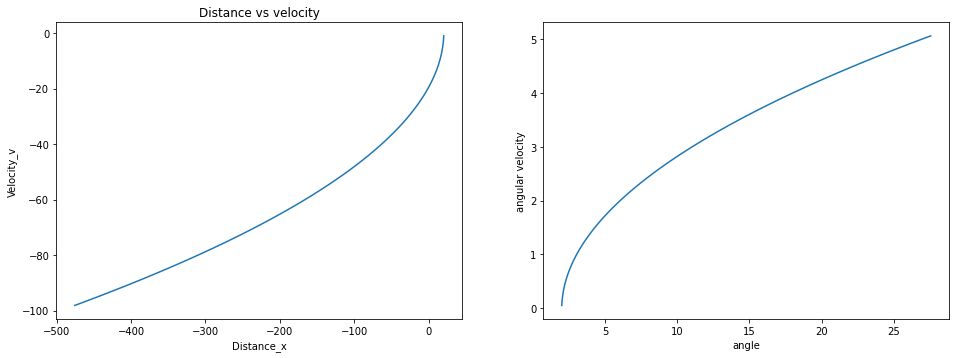

[17] loss: 236429.75000


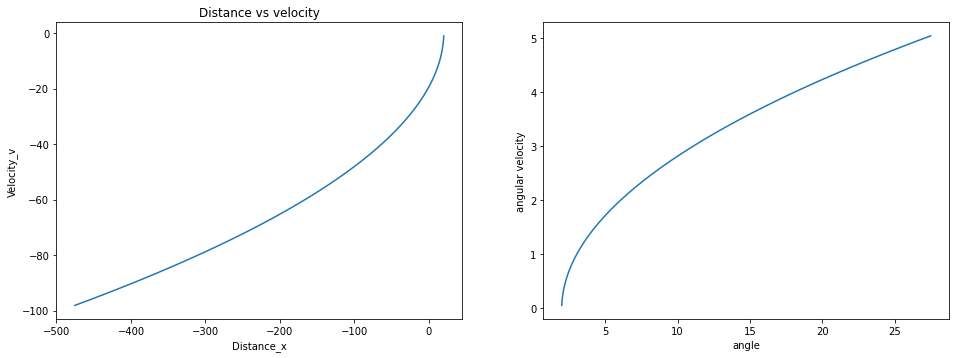

[18] loss: 236420.65625


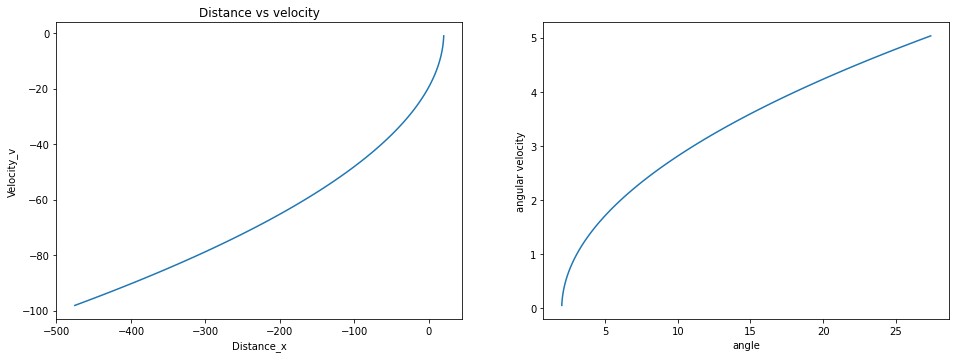

[19] loss: 236413.01562


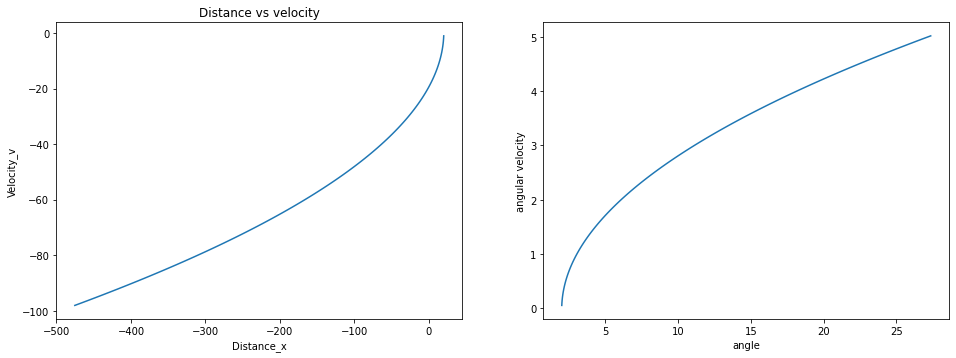

[20] loss: 236408.50000


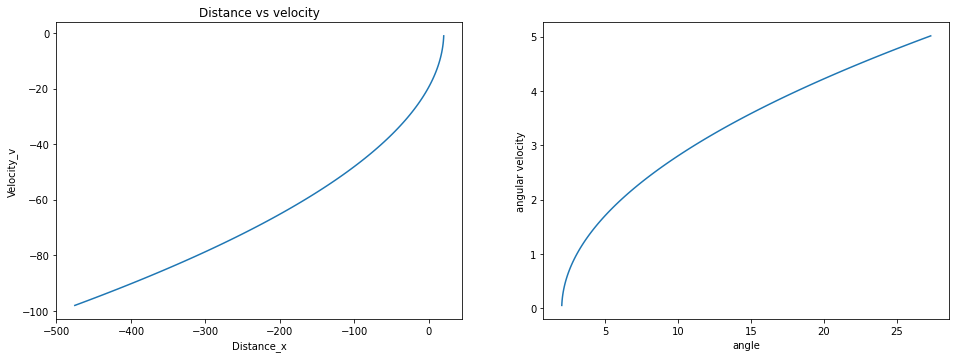

[21] loss: 236405.82812


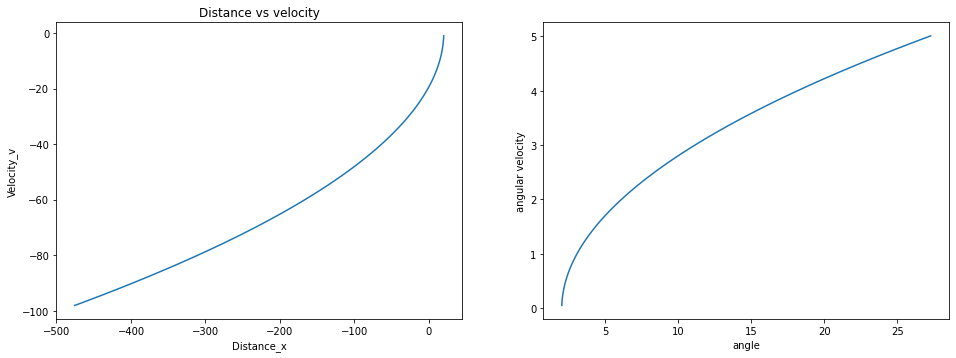

[22] loss: 236403.84375


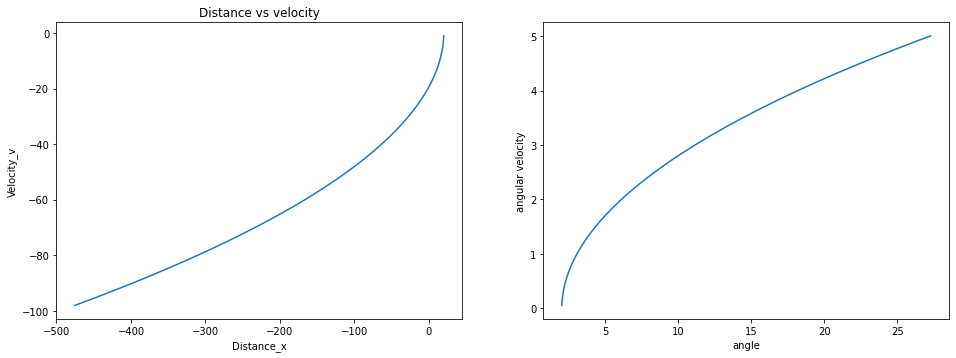

[23] loss: 236402.82812


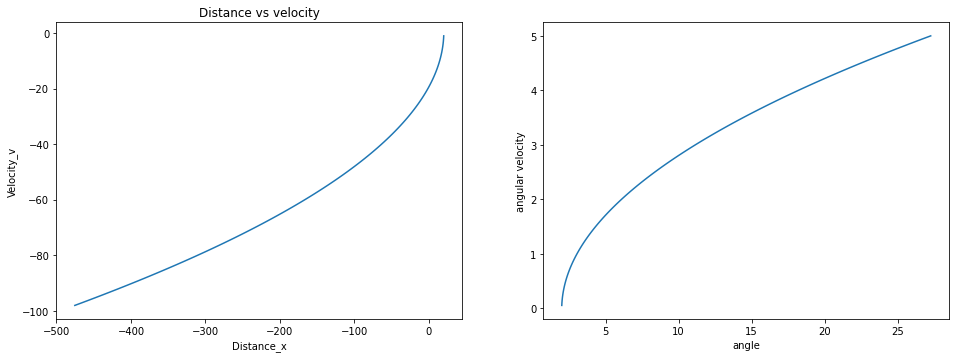

[24] loss: 236402.17188


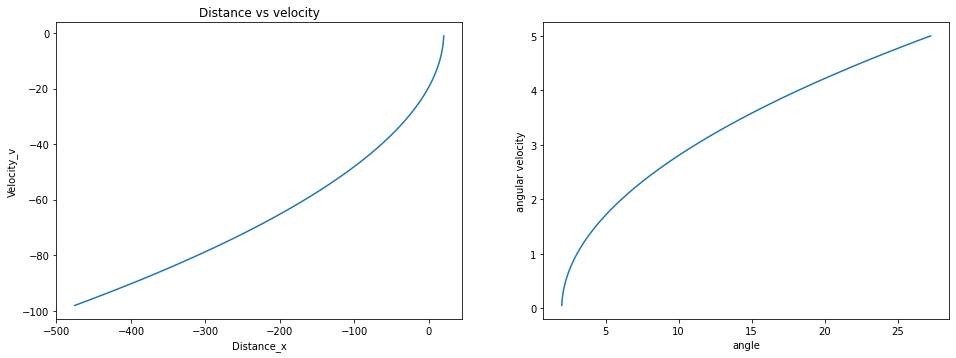

[25] loss: 236402.09375


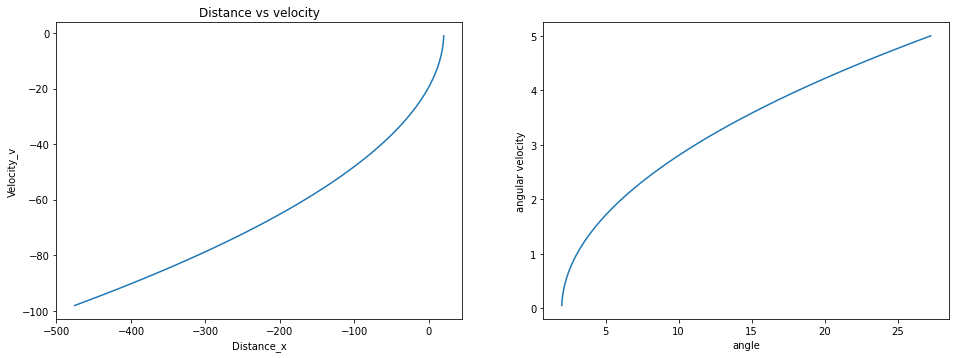

[26] loss: 236401.82812


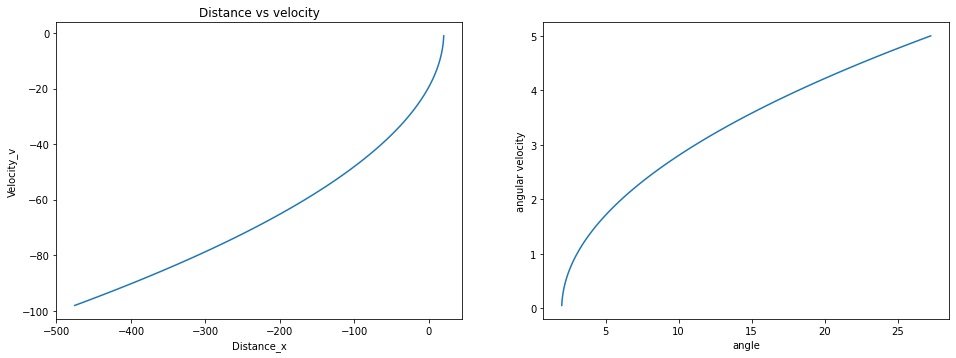

[27] loss: 236401.79688


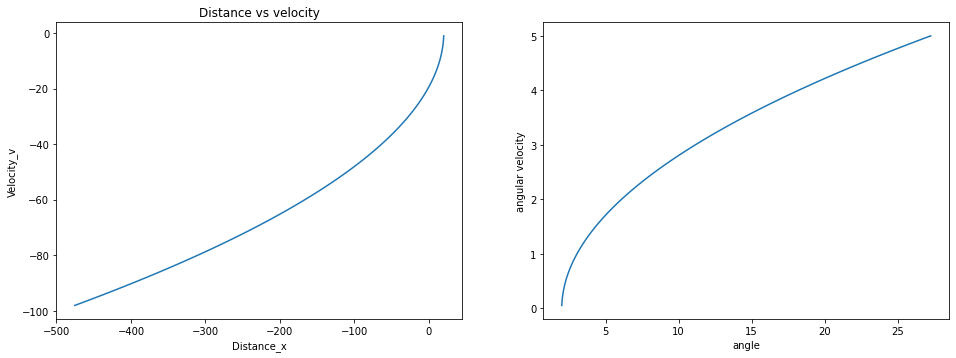

[28] loss: 236401.76562


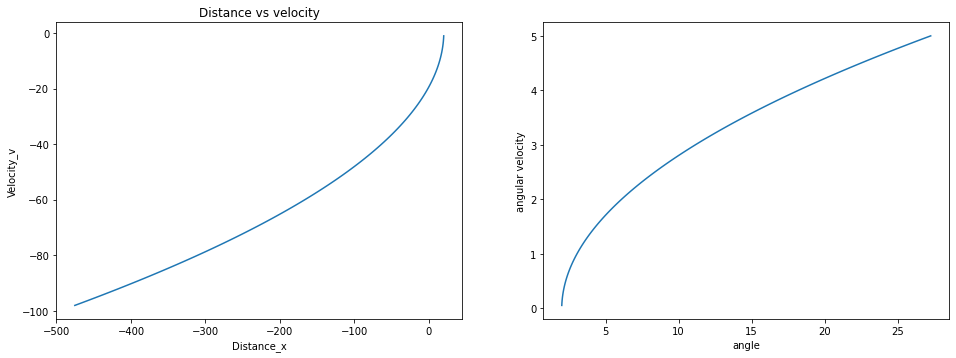

[29] loss: 236401.75000


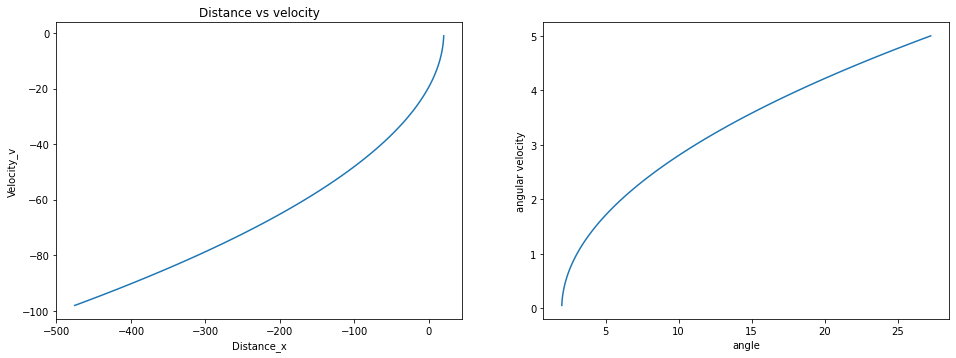

[30] loss: 236401.68750


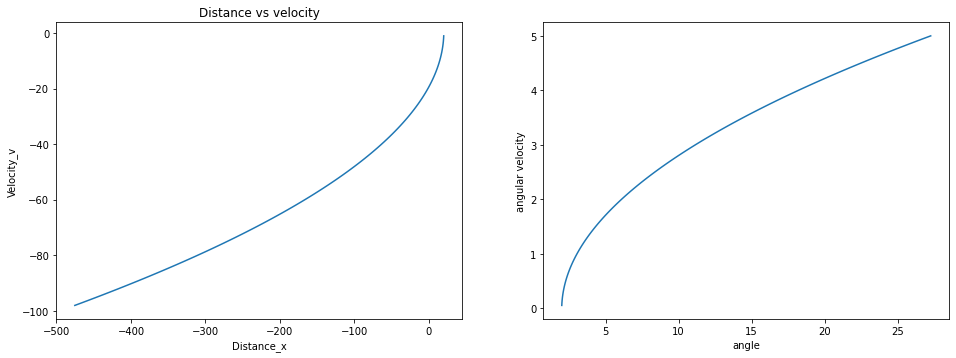

[31] loss: 236401.67188


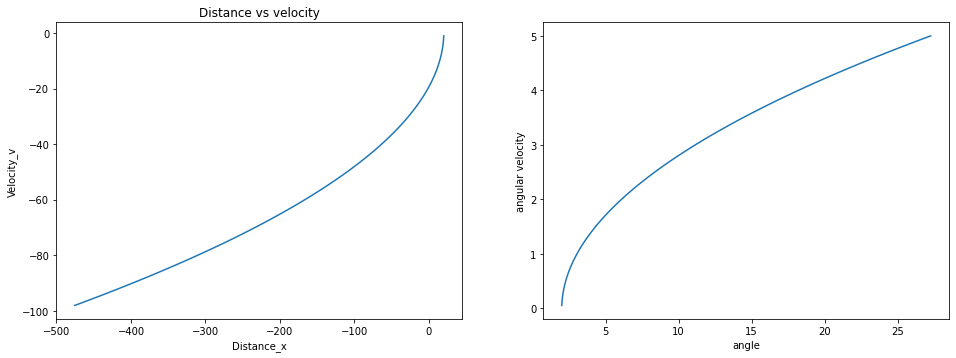

[32] loss: 236401.67188


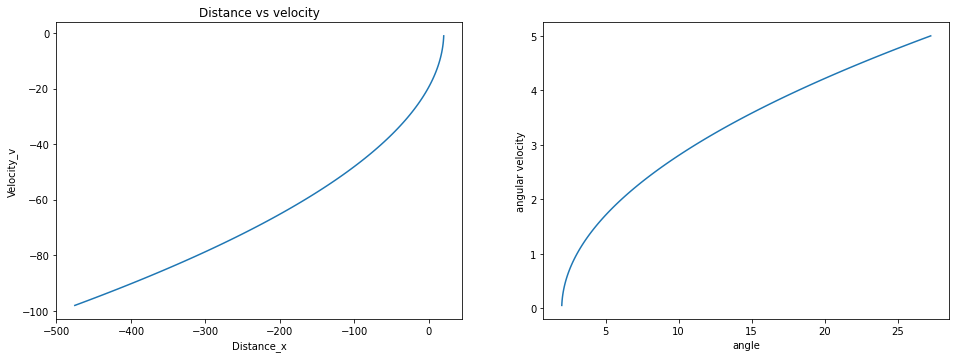

[33] loss: 236401.65625


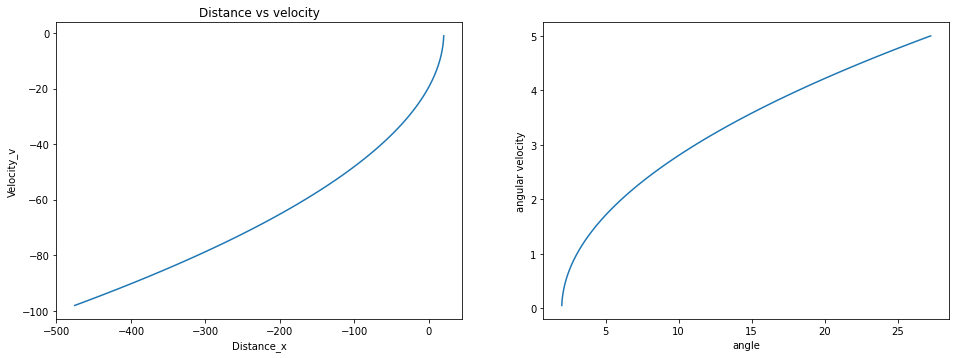

[34] loss: 236401.64062


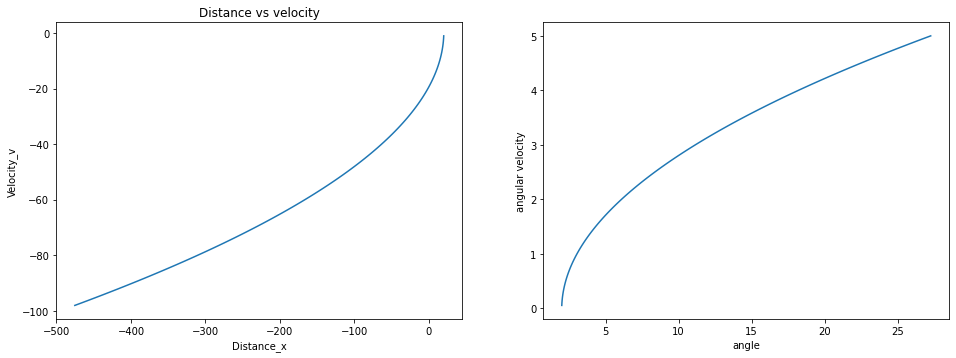

[35] loss: 236401.62500


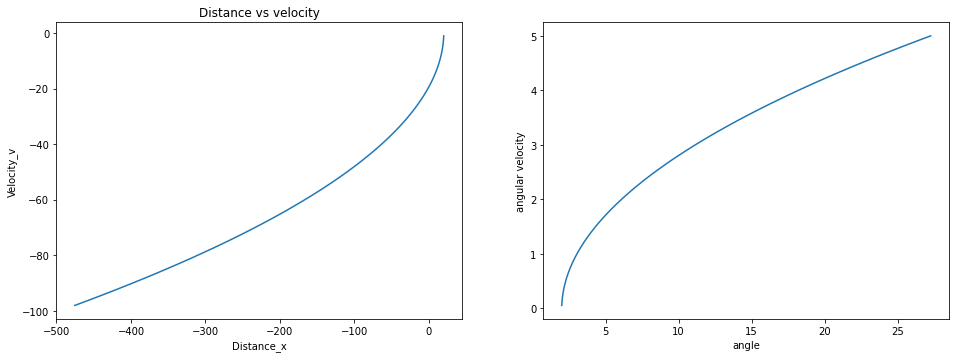

[36] loss: 236401.62500


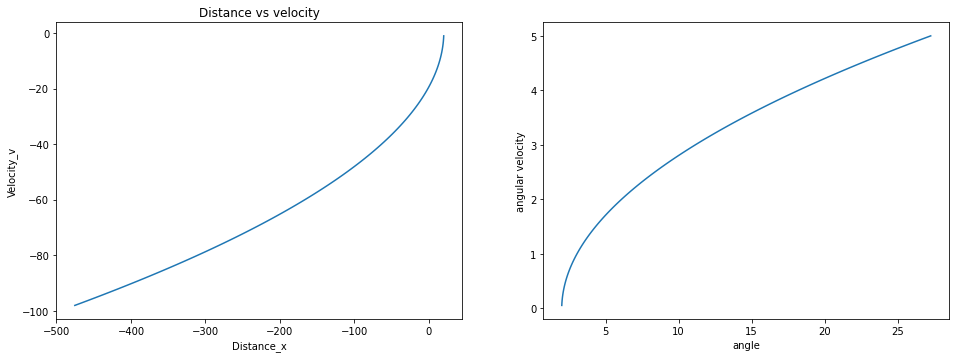

[37] loss: 236401.60938


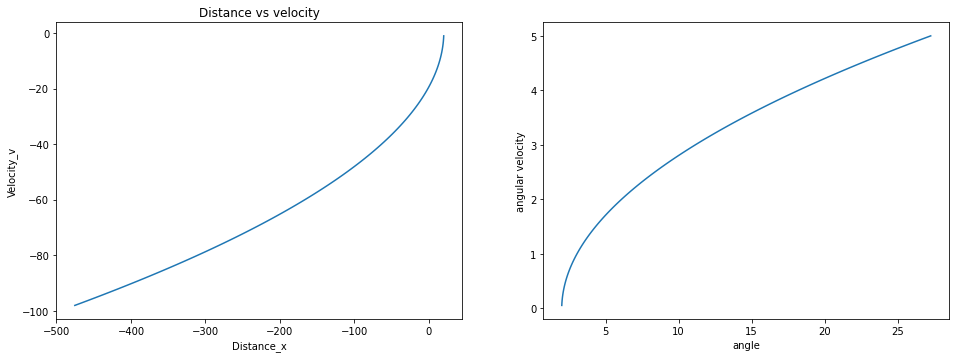

[38] loss: 236401.59375


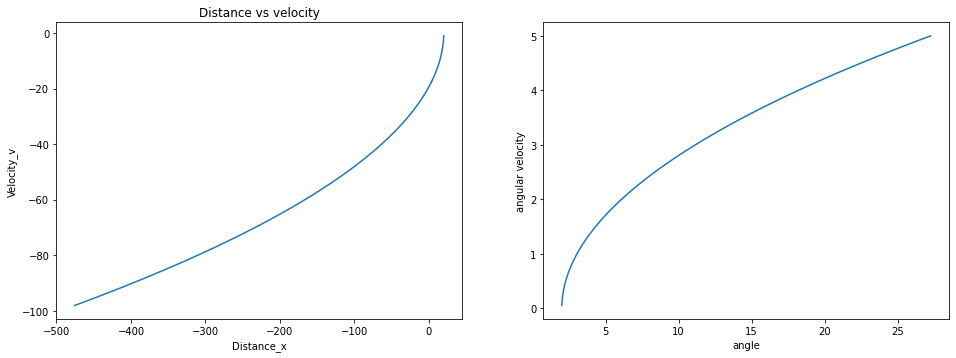

[39] loss: 236401.56250


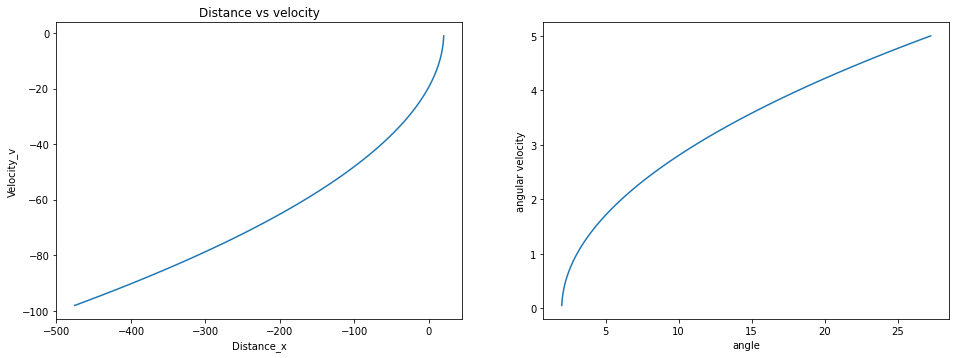

[40] loss: 236401.54688


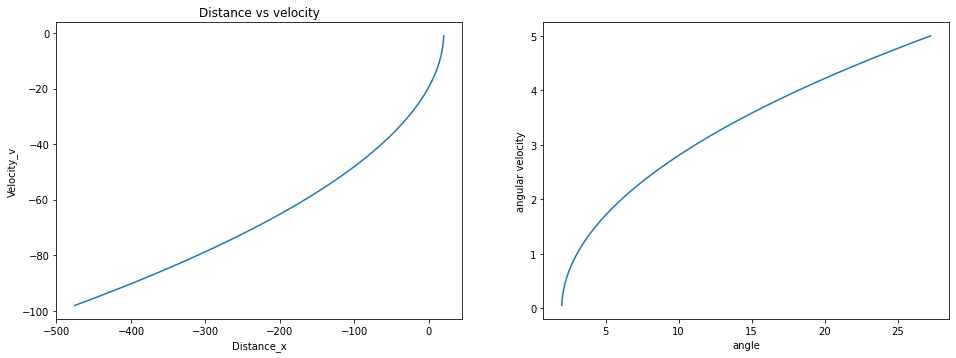

[41] loss: 236401.46875


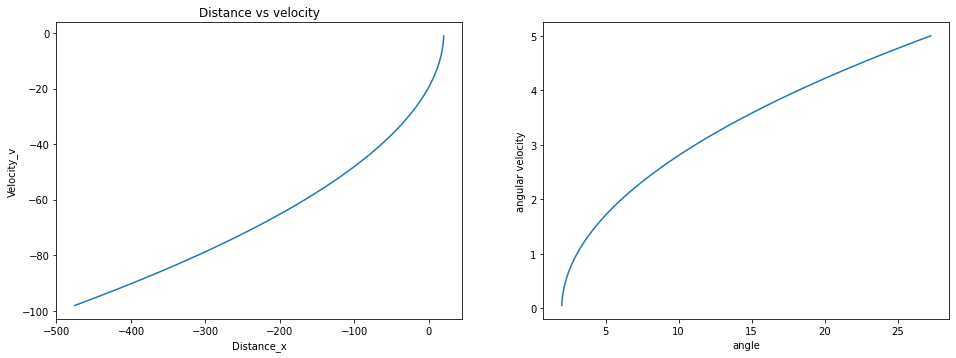

[42] loss: 236401.46875


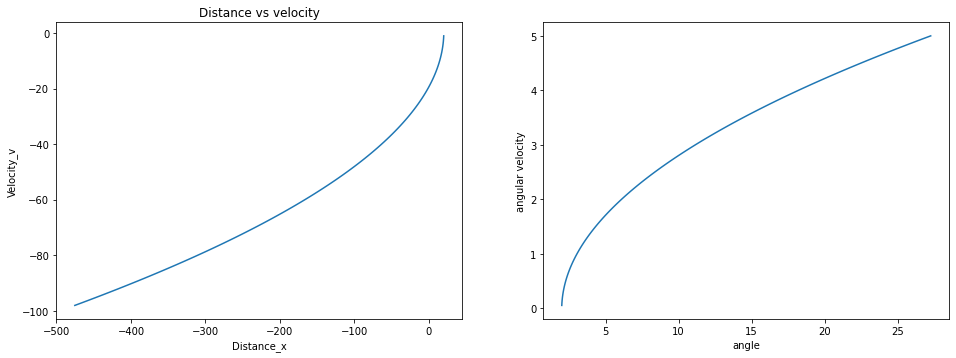

[43] loss: 236401.45312


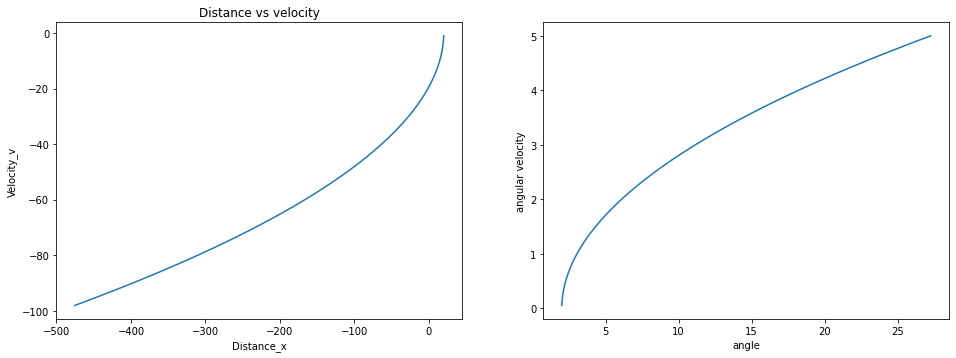

[44] loss: 236401.42188


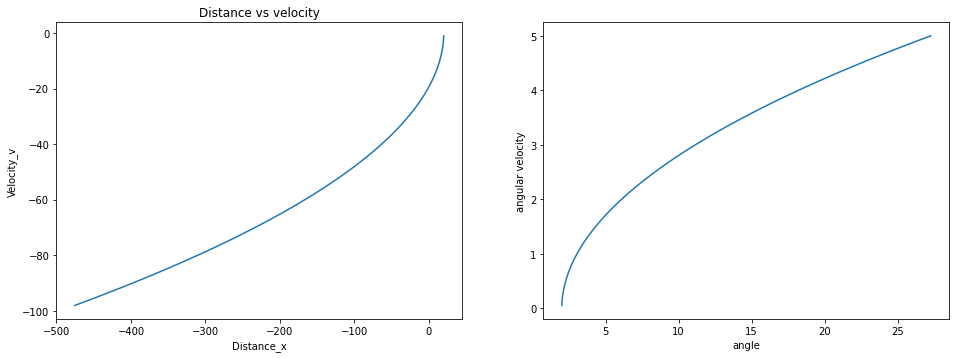

[45] loss: 236401.42188


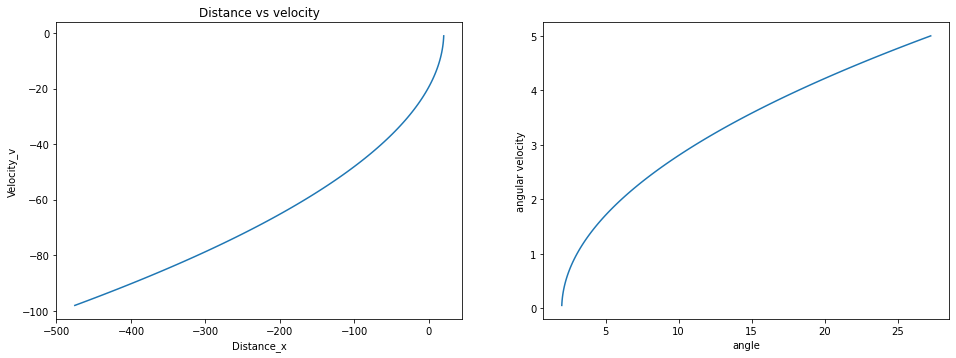

[46] loss: 236401.40625


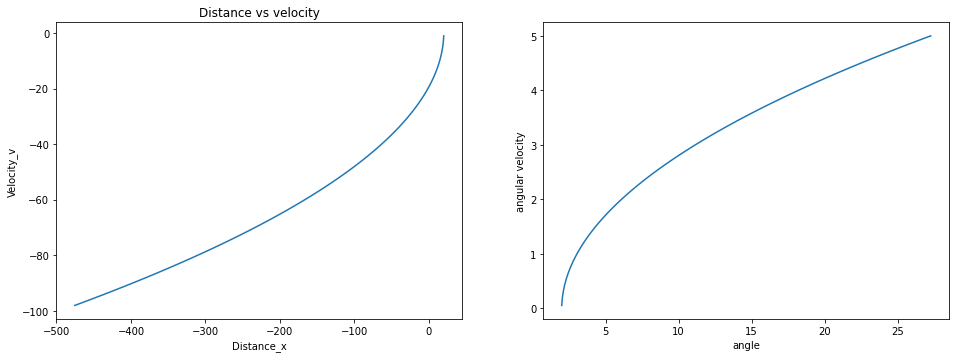

[47] loss: 236401.40625


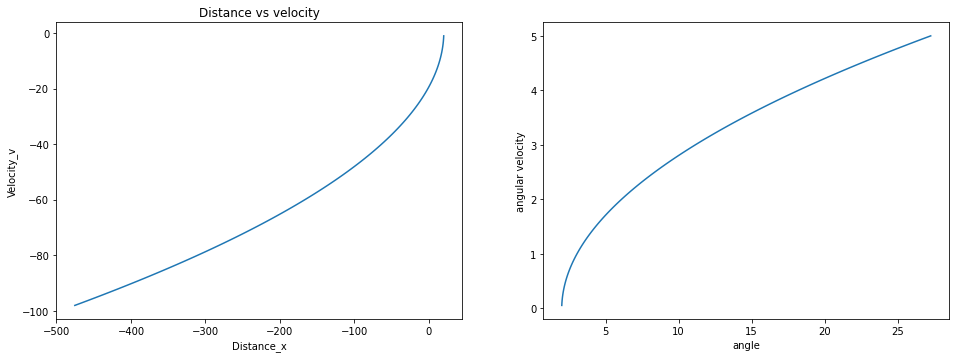

[48] loss: 236401.40625


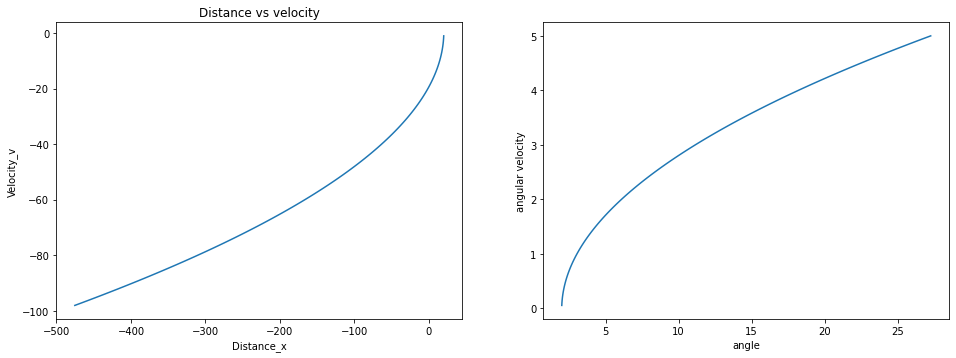

[49] loss: 236401.39062


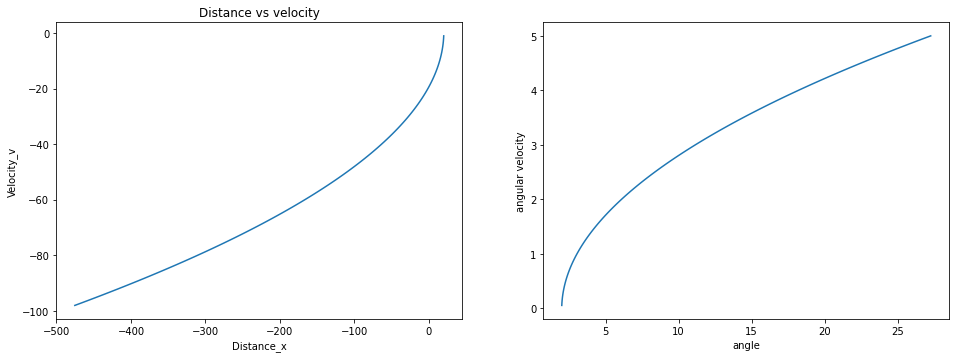

[50] loss: 236401.39062


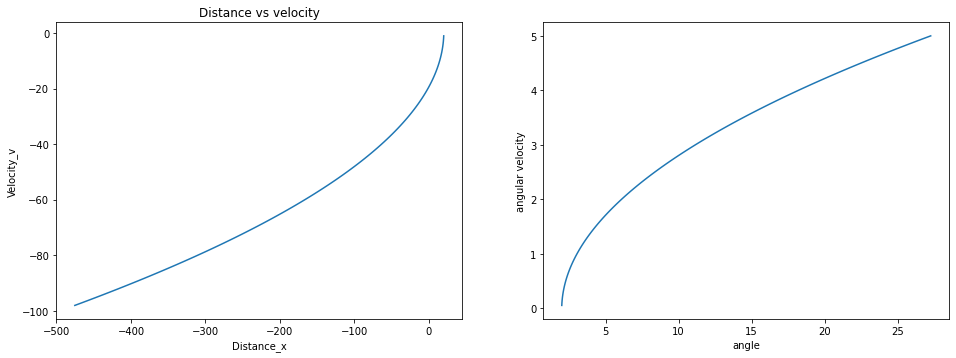

In [84]:

# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 12  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem

Conclusion: